In [33]:


import copy 
import pandas as pd 
import seaborn as sns
from sklearn.cluster import KMeans 
import numpy as np 
#read in raw counts, variable is mislabelled.
cpm = pd.read_csv('subread_counts.trimmed.txt', sep='\t', skiprows=1)





/tmp/ipykernel_697589/2209745558.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


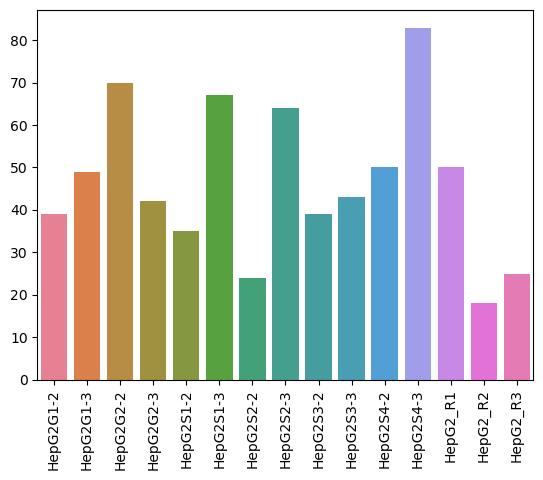

In [35]:
import matplotlib.pyplot as plt
ax= sns.barplot(cpm[cpm['Geneid'] == 'ENSG00000008128'].T[6:].T)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [36]:
#calculate tpm from raw reads

rpk = pd.DataFrame()
for value in cpm.T[6:].T.columns:
    rpk[value] = cpm[value]/cpm['Length']

tpm = pd.DataFrame()
for value in cpm.T[6:].T.columns:
    tpm[value] = np.log2(((rpk[value]/np.sum(rpk[value]))*1000000)+1)

tpm.insert(0, 'gene', cpm['Geneid'])
cpm = tpm

In [37]:
tpm
for value in tpm.columns:
    tpm[['gene', value]].to_csv(value+'_tpm.txt', sep='\t', index = False)

In [42]:
import qnorm
#quantile normalize with the average as the target dataset
tpm_norm=qnorm.quantile_normalize(tpm.T[1:].T, target=np.mean(tpm[['HepG2_R1','HepG2_R2','HepG2_R3']], axis=1))

/users/9/dicki214/.conda/envs/pandas/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/users/9/dicki214/.conda/envs/pandas/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='HepG2G1-2', ylabel='Count'>

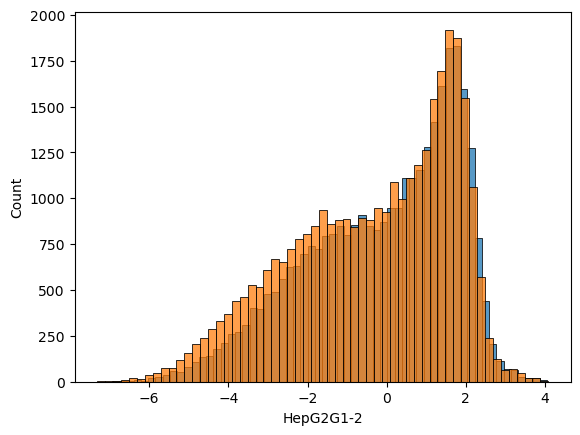

In [44]:
#plot pre-transformed distributions
sns.histplot(np.log2(tpm['HepG2G1-2']))
sns.histplot(np.log2(tpm['HepG2G1-3']))

/users/9/dicki214/.conda/envs/pandas/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/users/9/dicki214/.conda/envs/pandas/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='HepG2G1-2', ylabel='Count'>

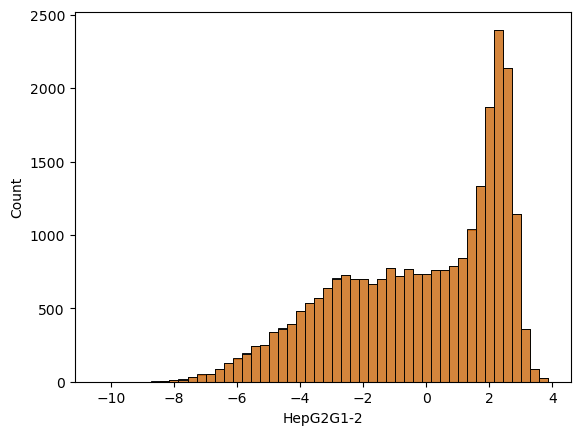

In [45]:
#plot transformed distributions
sns.histplot(np.log2(tpm_norm['HepG2G1-2'].astype(float)))
sns.histplot(np.log2(tpm_norm['HepG2G1-3'].astype(float)))

In [47]:
#insert gene names to tpm dataframe
tpm_norm.insert(loc=0, column='gene', value=tpm['gene'])

In [50]:
#tpm variable is used below for calculations, set the variable as normalized tpm
tpm = tpm_norm

/users/9/dicki214/.conda/envs/pandas/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


78932


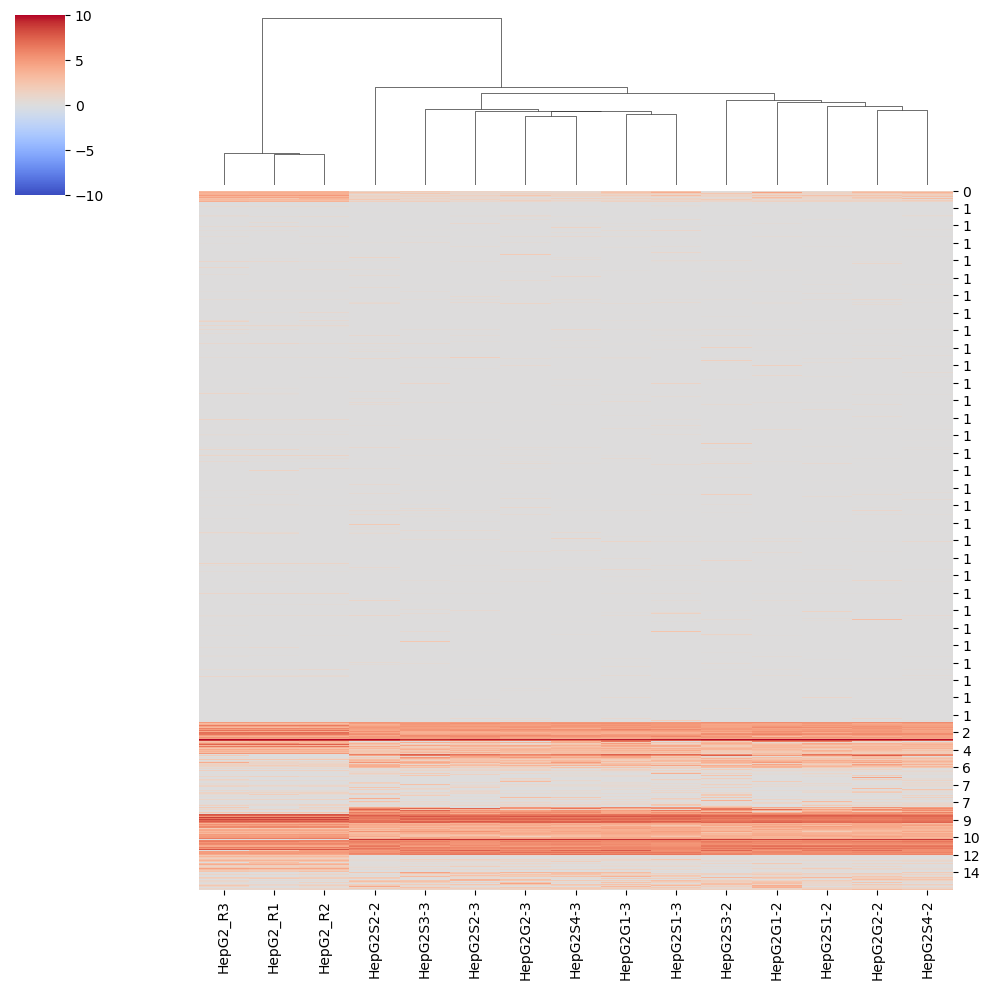

In [51]:
#cluster normalized tpm using kmeans and plot as a heatmap

tpm_kmeans = copy.deepcopy(tpm.T[1:].T)
kmeans = KMeans(n_clusters=15, random_state=0, n_init="auto").fit(tpm_kmeans.T[0:-1].T)
tpm_kmeans_display = copy.deepcopy(tpm_kmeans)
tpm_kmeans_display.index = kmeans.labels_
tpm_kmeans_display = tpm_kmeans_display.sort_index()
sns.clustermap(tpm_kmeans_display.T.astype(float).T, cmap='coolwarm', vmin=-10, vmax=10,row_cluster=False)
print(len(tpm_kmeans))
tpm_kmeans['cluster'] = kmeans.labels_
tpm_kmeans['gene'] = tpm['gene']
tpm_kmeans.to_csv('tpm_kmeans.csv')

In [54]:
#create an average tpm dataframe. As set, it will be the average of the normalized tpm data
tpm_avg = pd.DataFrame()
tpm_avg['gene'] = tpm['gene']

tpm_avg['bulk'] = np.mean(tpm[['HepG2_R1', 'HepG2_R2', 'HepG2_R3']], axis=1)

tpm_avg['G1'] = np.mean(tpm[['HepG2G1-2', 'HepG2G1-3']], axis=1)

tpm_avg['S1'] = np.mean(tpm[['HepG2S1-2', 'HepG2S1-3']], axis=1)

tpm_avg['S2'] = np.mean(tpm[['HepG2S2-2', 'HepG2S2-3']], axis=1)

tpm_avg['S3'] = np.mean(tpm[['HepG2S3-2', 'HepG2S3-3']], axis=1)

tpm_avg['S4'] = np.mean(tpm[['HepG2S4-2', 'HepG2S4-3']], axis=1)

tpm_avg['G2'] = np.mean(tpm[['HepG2G2-2', 'HepG2G2-3']], axis=1)

tpm_avg

,gene,bulk,G1,S1,S2,S3,S4,G2
0,ENSG00000142611,0.003604,0.29734,0.0,0.03488,0.068995,0.071278,0.095776
1,ENSG00000284616,0.003604,0.0,0.055549,0.0,0.171756,0.051641,0.0
2,ENSG00000157911,5.680501,5.483472,5.135356,5.175439,5.794697,5.596019,5.533479
3,ENSG00000260972,0.003604,0.0,0.0,0.0,0.0,0.029571,0.0
4,ENSG00000224340,0.003604,0.0,0.199779,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
78927,ENSG00000307722,0.003604,0.0,0.0,0.0,0.0,0.0,0.0
78928,ENSG00000310401,0.003604,0.0,0.0,0.0,0.0,0.0,0.0
78929,ENSG00000302039,1.514658,0.028401,0.076553,0.0,0.011567,0.0,0.0
78930,ENSG00000309831,0.080418,0.152046,0.100401,0.189792,0.205845,0.0,0.0


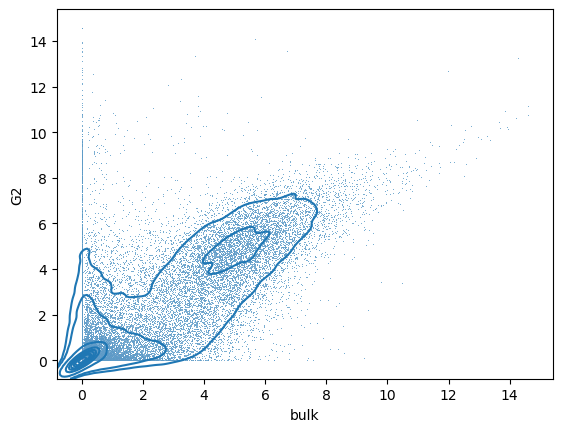

In [55]:
#plot a scatterplot to compare partage to the bulked dataset
sns.scatterplot(data=tpm_avg, x='bulk', y='G2', s=0.5)
sns.kdeplot(data=tpm_avg, x='bulk', y='G2')
plt.savefig('bulk_G2_scatter.pdf')
plt.savefig('bulk_G2_scatter.png')
plt.savefig('bulk_G2_scatter.svg')
plt.show()

In [58]:
import matplotlib.pyplot as plt

/users/9/dicki214/.conda/envs/pandas/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


78932


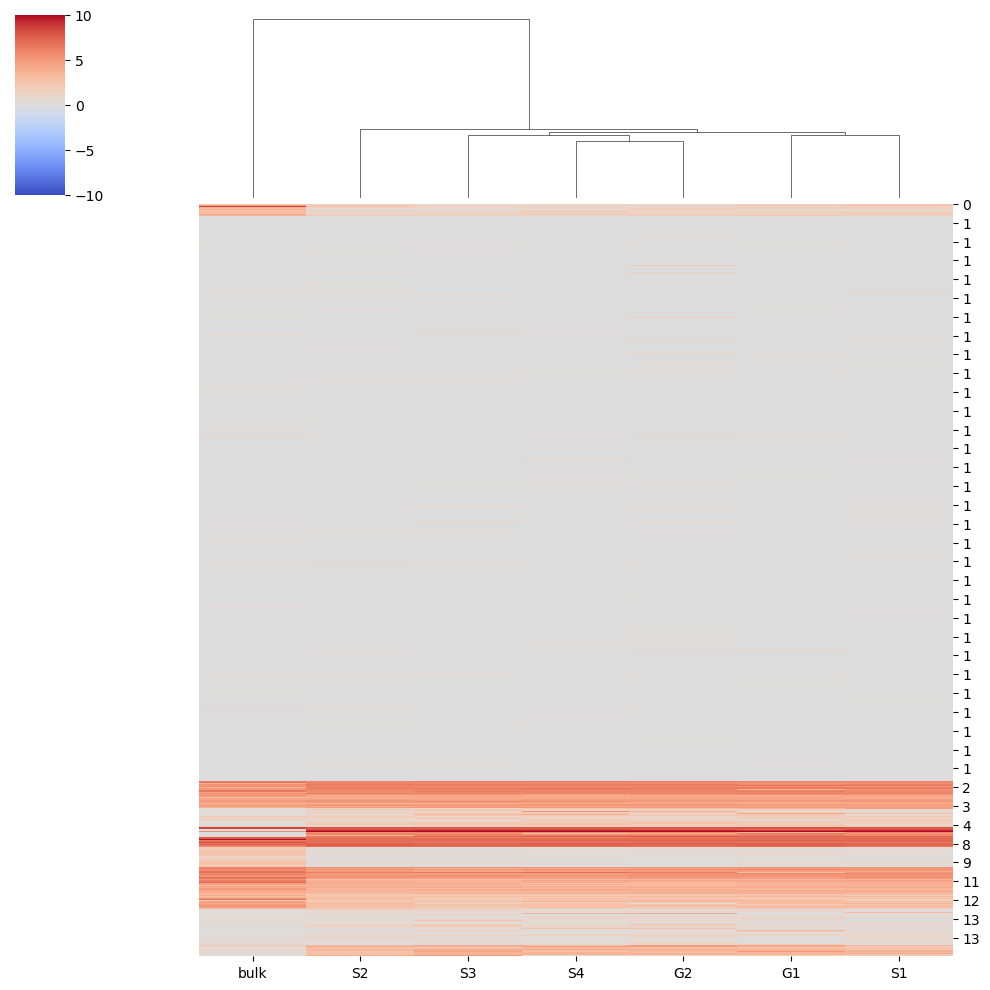

In [59]:
#cluster and plot the average values for partage
tpm_kmeans = copy.deepcopy(tpm_avg.T[1:].T)
kmeans = KMeans(n_clusters=15, random_state=0, n_init="auto").fit(tpm_kmeans.T[0:-1].T)
tpm_kmeans_display = copy.deepcopy(tpm_kmeans)
tpm_kmeans_display.index = kmeans.labels_
tpm_kmeans_display = tpm_kmeans_display.sort_index()
sns.clustermap(tpm_kmeans_display.T.astype(float).T, cmap='coolwarm', vmin=-10, vmax=10,row_cluster=False)
plt.savefig('rna_avg_all_partage.png')
plt.savefig('rna_avg_all_partage.svg')
plt.savefig('rna_avg_all_partage.pdf')
print(len(tpm_kmeans))
tpm_kmeans['cluster'] = kmeans.labels_
tpm_kmeans['gene'] = tpm['gene']
tpm_kmeans.to_csv('tpm_kmeans.csv')


In [61]:
tpm_corr=tpm.T.iloc[1:16].T.corr()

In [62]:
# tpm_nozero=tpm.replace(0, np.nan)
# tpm_nozero = tpm_nozero.dropna()
tpm_corr=tpm_avg.T.iloc[1:].T.corr()

In [ ]:
#create correlation heatmap for average partage
sns.heatmap(tpm_corr, vmin=0, vmax=1)#, center=0.1)
plt.savefig('rna_corr_matrix_partage_avg.png')
plt.savefig('rna_corr_matrix_partage_avg.svg')
plt.savefig('rna_corr_matrix_partage_avg.pdf')

In [ ]:
#create correlation heatmap for all partage samples
sns.heatmap(tpm_corr, vmin=0, vmax=1)#, center=0.1)
plt.savefig('rna_corr_matrix_partage_all.png')
plt.savefig('rna_corr_matrix_partage_all.svg')
plt.savefig('rna_corr_matrix_partage_all.pdf')

In [65]:
#read in the pseudo E/L data
pseudo = pd.read_csv('RT_50000_qNorm_Smoothed_10Kb2025-07-22.txt', sep='\t')

In [67]:
#get gene positions, names, and contigs and add them to the dataframe

from pyensembl import EnsemblRelease
data = EnsemblRelease(86)



data = EnsemblRelease(86)
gene_names = []
gene_contig = []
gene_start = []
gene_end = []
for value in list(tpm['gene']):
    try:
        gene = data.gene_by_id(value)
        gene_contig.append(gene.contig)
        gene_start.append(gene.start)
        gene_end.append(gene.end)

        gene_names.append(data.gene_name_of_gene_id(value))
    except ValueError:
        gene_names.append(value)
        gene_contig.append(np.nan)
        gene_start.append(np.nan)
        gene_end.append(np.nan)
tpm['name'] = gene_names
tpm['chr'] = gene_contig
tpm['start'] = gene_start
tpm['end'] = gene_end

In [69]:
#Use the pseudo E/L to get the replication timing at each gene.
import warnings
warnings.filterwarnings('ignore')
repliseq_by_gene = pd.DataFrame()
rna_by_gene = copy.copy(tpm.dropna())
script_quant = copy.copy(pseudo)
ind = 0
for chromosome in range(1,23):
    chromo_script_quant = script_quant[script_quant['Chromosome'] == ('chr'+str(chromosome))]
    chromo_genes = rna_by_gene[rna_by_gene["chr"].astype(str) == (str(chromosome))]
    i = 0
    while i < len(chromo_genes):
        entry = [chromosome]
        entry= []
        entry.append(chromo_genes.iloc[i]['gene'])  
        entry.append(chromo_genes.iloc[i]['name'])  
        entry.append(chromosome)
        entry.append(chromo_genes.iloc[i]['start'])
        entry.append(chromo_genes.iloc[i]['end'])
        #entry.append(chromo_genes.iloc[i]['End'])
        
        temp = chromo_script_quant[chromo_script_quant['Position'].astype(int)>int(chromo_genes.iloc[i]['start'])]
        temp = temp[temp['Position'].astype(int)<int(chromo_genes.iloc[i]['end'])]
            
        
        
       
        for column in temp.columns[2:]:
            
            entry.append(np.mean(temp[column]))
        repliseq_by_gene[ind] = entry
        ind+=1
        
        
        
        
        i+=1
repliseq_by_gene = repliseq_by_gene.T

In [71]:
repliseq_by_gene = repliseq_by_gene.dropna()

In [74]:
#get the average for expression to use to create dirkplots
rna_by_gene['average']=np.mean(rna_by_gene[['HepG2_R1', 'HepG2_R2', 'HepG2_R3']], axis=1)

In [75]:
#Dirkplots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

#define number of bins and groups used for dirkplot histograms
#calculate a linear model to determine the slope of the correlation between expression and rt

def dirkplot(x, y, ngroup=100, bins=100, nbins=None, pcol='lightgray', xlim=[-6,6], xlab='x', ylab='y', title='Dirkplot'):
    df = pd.DataFrame({'x': x, 'y': y})
    df1 = df
    # df1 = df[df['x'] < -0.5]
    # df2 = df[df['x'] > 0.5]
    
    model1 = sm.GLM(df1['y'], sm.add_constant(df1['x']), family=sm.families.Gaussian()).fit()
    #model2 = sm.GLM(df2['y'], sm.add_constant(df2['x']), family=sm.families.Binomial()).fit()
    
    if nbins is None:
        nbins = round(len(x) / ngroup)
    
    sorted_indices = np.argsort(x)
    x_sorted = np.array(x)[sorted_indices]
    y_sorted = np.array(y)[sorted_indices]
    y_cumsum = np.cumsum(y_sorted)
    
    tt = np.round((np.arange(0, nbins) * len(x) / nbins)).astype(int)
    yt = np.diff(np.insert(y_cumsum[tt - 1], 0, 0))
    zt = np.diff(np.insert(tt, 0, 0))
    yt = yt / zt
    
    x_bins = np.insert(x_sorted[tt - 1], [0, len(x_sorted)], [min(x_sorted), max(x_sorted)])
    x_mid = (x_bins[:-1] + x_bins[1:]) / 2
    
    if xlim is None:
        xlim = (min(x_mid), max(x_mid))
    
    
    
    uu = np.linspace(min(x_mid), max(x_mid), 1000)
    ff = sm.add_constant(uu)

    values = x # Continuous values
    binary_labels = y  # Binary labels
    
    # Define bins
    num_bins = bins
    bin_edges = np.linspace(min(values), max(values), num_bins + 1)
    
    # Compute bin indices for each value
    bin_indices = np.digitize(values, bin_edges) - 1  # Adjust to 0-based index
    
    # Calculate proportion of 1s in each bin
    proportions = []
    for i in range(num_bins):
        in_bin = binary_labels[bin_indices == i]
        if len(in_bin) > 0:
            proportions.append(np.mean(in_bin))  # Mean gives proportion of 1s
        else:
            proportions.append(0)  # If no data in bin, set proportion to 0
    
    # Plot histogram using bar chart
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers
    
    
    

    
    
    pred1 = model1.get_prediction(ff)
    #pred2 = model2.get_prediction(ff)
    
    y2 = pred1.predicted_mean
    y1 = pred1.conf_int()[:, 0]
    y3 = pred1.conf_int()[:, 1]
    const, slope = model1.params
    plt.figure(figsize=(8, 5))
    plt.xlim(xlim)
    plt.ylim(0, 1)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    #plt.fill_between(x_mid[1:], 0, yt, color=pcol)
    plt.grid(False, linestyle='--', alpha=0.5)
    plt.bar(bin_centers, proportions, width=np.diff(bin_edges), align='center', edgecolor='black', alpha=0.7)
    plt.plot(uu, y2, linewidth=3)
    plt.plot(uu, y1, linestyle='dashed')
    plt.plot(uu, y3, linestyle='dashed')
    plt.text(-5, 0.85, "y="+str(round(slope, 4))+"x+"+str(round(const,4)))
    plt.title(title)
    
    plt.savefig(title+'_const_dirkplot.png')
    plt.savefig(title+'_const_dirkplot.svg')
    plt.savefig(title+'_const_dirkplot.pdf')
    plt.show()

In [76]:
rna_by_gene.index = rna_by_gene['gene']

In [77]:
repliseq_by_gene.columns = ['id', 'name', 'chr', 'start', 'end', 'HepG2', 'rep1', 'rep2', 'rep3']
repliseq_by_gene.index = repliseq_by_gene['id']

In [78]:
#get dataframe with only values present in both RT and RNA data
rna_by_gene_overlap = rna_by_gene.T[list(repliseq_by_gene['id'])].T

0.3436382187528069


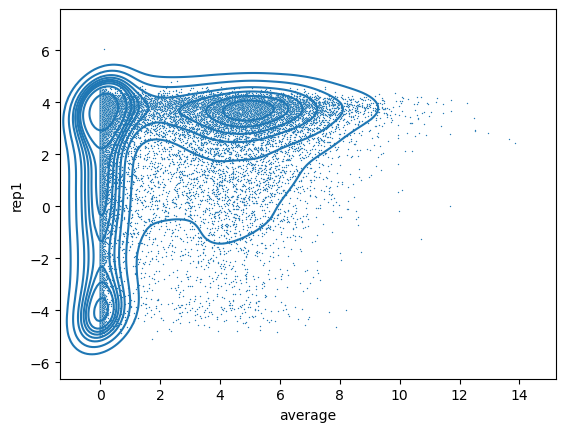

In [93]:
from scipy.stats import spearmanr
#plot direct values of expression and RT and calculate overall correlation
correlation, p_value = spearmanr(rna_by_gene_overlap['average'], repliseq_by_gene['rep1'])
sns.kdeplot(x=rna_by_gene_overlap['average'], y=repliseq_by_gene['rep1'])
sns.scatterplot(x=rna_by_gene_overlap['average'], y=repliseq_by_gene['rep1'], s=1)
print(correlation)

In [80]:
#create binary list for gene expression. tpm>=1 is expressed

rna_by_gene_overlap = rna_by_gene[['average']]
rna_by_gene_overlap = rna_by_gene_overlap.T[list(repliseq_by_gene['id'])].T
rna_by_gene_binary = copy.copy(rna_by_gene_overlap)


condition = rna_by_gene_binary>=1

rna_by_gene_binary = rna_by_gene_binary.mask(condition, 1)
condition = rna_by_gene_binary<1
rna_by_gene_binary = rna_by_gene_binary.mask(condition, 0)
rna_by_gene_binary

,average
gene,
ENSG00000142611,0
ENSG00000157911,1
ENSG00000142655,1
ENSG00000232596,0
ENSG00000231510,0
...,...
ENSG00000250261,0
ENSG00000215771,0
ENSG00000231993,0


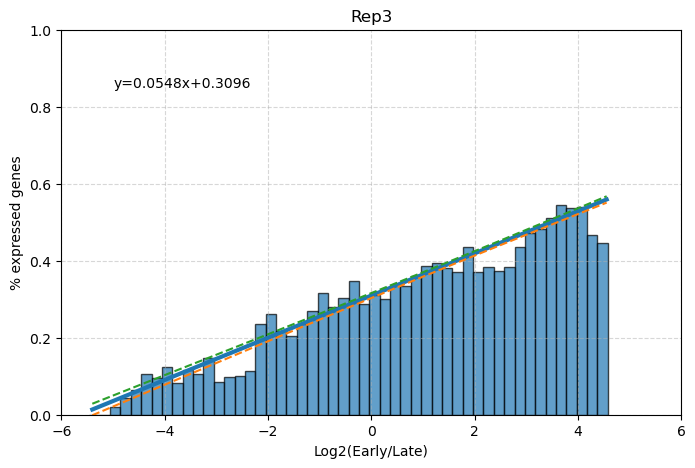

In [233]:
#'HepG2', 'rep1', 'rep2', 'rep3'
#create dirkplot for given sample
dirkplot(np.array(repliseq_by_gene['rep3']).astype(float), np.array(rna_by_gene_binary['average']).astype(float), 
         ngroup=1, bins=50, xlab='Log2(Early/Late)', ylab='% expressed genes', title = 'Rep3')



<Axes: >

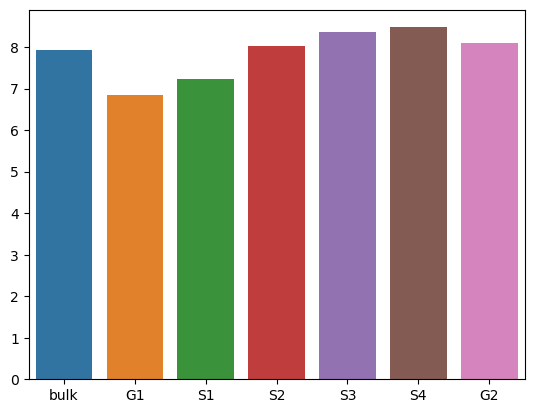

In [61]:
sns.barplot(tpm_avg[tpm_avg['gene'] == 'ENSG00000131747'].T[1:].T)

In [152]:
#Create a subset of TPM dataframe based on the expression of the gene being greater or equal to tpm 2

tpm_subset=copy.deepcopy(tpm_avg[['gene', 'G1', 'S1', 'S2', 'S3', 'S4', 'G2']])
#tpm_subset=copy.deepcopy(tpm[['gene', 'HepG2G1-2', 'HepG2G1-3', 'HepG2G2-2', 'HepG2G2-3', 'HepG2S1-2',
#       'HepG2S1-3', 'HepG2S2-2', 'HepG2S2-3', 'HepG2S3-2', 'HepG2S3-3',
#       'HepG2S4-2', 'HepG2S4-3', 'HepG2_R1', 'HepG2_R2', 'HepG2_R3']])
# sample_subset=['genes', 'HepG2G1.2', 'HepG2G1.3', 'HepG2G2.2', 'HepG2G2.3',
#        'HepG2S1.2', 'HepG2S1.3', 'HepG2S2.2', 'HepG2S2.3', 'HepG2S3.2',
#        'HepG2S3.3', 'HepG2S4.2', 'HepG2S4.3',]
# tpm_subset = tpm_subset[sample_subset]
mins=[]
maxs=[]
for i in range(0,len(tpm_subset)):
    mins.append(min(tpm_subset.iloc[i][1:]))
    maxs.append(max(tpm_subset.iloc[i][1:]))  
    
tpm_subset['min'] = mins
tpm_subset['max'] = maxs

tpm_subset = tpm_subset[tpm_subset['max']>=2]


tpm_subset.drop('max', axis = 1, inplace=True)
tpm_subset.drop('min', axis = 1, inplace=True)

In [153]:
#differences of the minimum value of a sample and maximum must be 4 to have considered differential expression
differences = []
for i in range(0,len(tpm_subset)):
    differences.append(max(list(tpm_subset.iloc[i][1:]))-min(list(tpm_subset.iloc[i][1:])))
tpm_subset['differences'] = differences
tpm_subset = tpm_subset[tpm_subset['differences'] > 4]
tpm_subset.drop('differences', axis = 1, inplace=True)

In [154]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

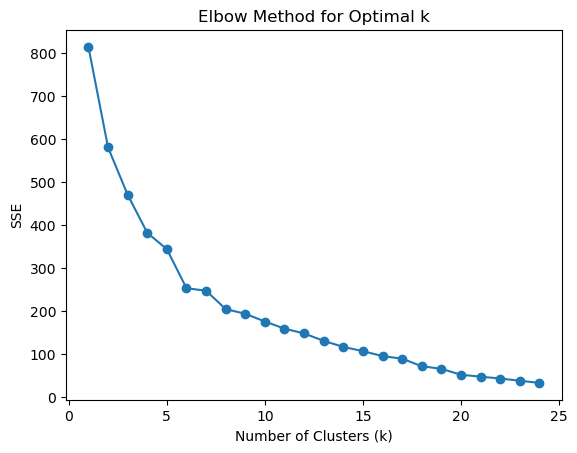

In [155]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#use elbow method to determine an optimal number of clusters for k-means


sse = []
k_range = range(1, 25) # Example range for k

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') # n_init='auto' for modern sklearn versions
    kmeans.fit(tpm_subset.T[1:].T)
    sse.append(kmeans.inertia_)
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.savefig('elbow_plot_all_expall_changeall.png')
plt.savefig('elbow_plot_all_expall_changeall.svg')
plt.savefig('elbow_plot_all_expall_changeall.pdf')
plt.show()

In [162]:
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)

42


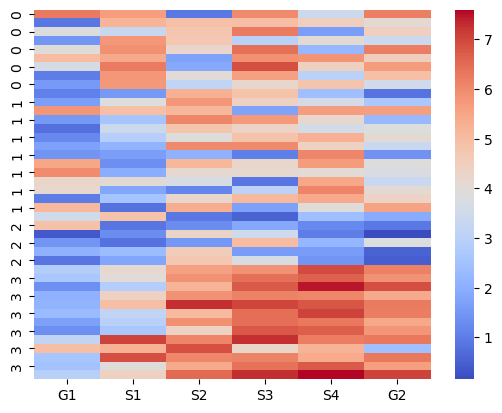

In [165]:
tpm_kmeans = copy.deepcopy(tpm_subset.T[1:].T)

# scaler = MinMaxScaler()
# tpm_kmeans_scaled = scaler.fit_transform(tpm_kmeans.T).T

# pca = PCA()
# pc_tpm = pca.fit_transform(tpm_kmeans_scaled)
# pc_tpm = tpm_kmeans
#tpm_kmeans = copy.deepcopy(tpm_quantile)
#This line calculates the clusters using the k-means algorithm
#kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(embedding)

kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(tpm_kmeans.T[1:-1].T)

#This line makes another copy of the dataframe to display with seaborn
tpm_kmeans_display = copy.deepcopy(pd.DataFrame(tpm_kmeans))
#This line makes the index of the created dataframe into the cluster, so it can be sorted correctly
tpm_kmeans_display.index = kmeans.labels_
#This line sorts the data by the index i.e. the cluster it is in.
tpm_kmeans_display = tpm_kmeans_display.sort_index()
#This line creates the heatmap for your data. vmin and vmax options control the color mapping to data values
sns.heatmap(tpm_kmeans_display.T.astype(float).T, cmap='coolwarm', 
               #vmin=-2, vmax=8,
               #row_cluster=False
           )
#This line prints the total number of genes present in the dataset
print(len(tpm_kmeans))

plt.savefig('rna_heatmap_all_expall_changeall.png')
plt.savefig('rna_heatmap_all_expall_changeall.svg')
plt.savefig('rna_heatmap_all_expall_changeall.pdf')

In [166]:
#These lines add the cluster and gene names to the copied dataset
tpm_kmeans['cluster'] = kmeans.labels_
tpm_kmeans['gene'] = tpm_subset['gene']
#tpm_kmeans['gene'] = tpm_subset.reset_index()['genes']
#This line exports a new "excel" file in .csv format, containing the cluster information.
tpm_kmeans.to_csv('tpm_kmeans_all_exp1_change1.csv')


In [87]:
tpm_kmeans_cluster = tpm_kmeans

In [253]:
#read in genes from clustering analysis
genes = pd.read_csv('tpm_avg_log2TPM_zscored_clusters.txt', skiprows=1,header=None, sep='\t')

In [254]:
genes=list(genes[genes[11] == 2][1])

In [255]:
#calculate enrichment analysis for gene list
enr = gp.enrichr(gene_list=genes, # or "./tests/data/gene_list.txt",
                                 gene_sets=[
                                     # 'GO_Biological_Process_AutoRIF',
                                     # 'MSigDB_Hallmark_2020',
                                     #        'KEGG_2021_Human', 
                                     #        'GO_Biological_Process_2023',
                                     #        'GO_Cellular_Component_2023',
                                     #       'GO_Molecular_Function_2023'
                                    # 'ARCHS4_Cell-lines',
 #'ARCHS4_IDG_Coexp',
 #'ARCHS4_Kinases_Coexp',
 #'ARCHS4_TFs_Coexp',
 #'ARCHS4_Tissues',
 #'Achilles_fitness_decrease',
 #'Achilles_fitness_increase',
 #'Aging_Perturbations_from_GEO_down',
 #'Aging_Perturbations_from_GEO_up',
 #'Allen_Brain_Atlas_10x_scRNA_2021',
 #'Allen_Brain_Atlas_down',
 #'Allen_Brain_Atlas_up',
 #'Azimuth_2023',
 #'Azimuth_Cell_Types_2021',
 #'BioCarta_2013',
 #'BioCarta_2015',
 #'BioCarta_2016',
 #'BioPlanet_2019',
 #'BioPlex_2017',
 #'CCLE_Proteomics_2020',
 #'COMPARTMENTS_Curated_2025',
 #'COMPARTMENTS_Experimental_2025',
 #'CORUM',
 #'COVID-19_Related_Gene_Sets',
 #'COVID-19_Related_Gene_Sets_2021',
 #'Cancer_Cell_Line_Encyclopedia',
 #'CellMarker_2024',
 #'CellMarker_Augmented_2021',
 #'ChEA_2013',
 #'ChEA_2015',
 #'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 #'Chromosome_Location_hg19',
 #'ClinVar_2019',
 #'DGIdb_Drug_Targets_2024',
 #'DSigDB',
 #'Data_Acquisition_Method_Most_Popular_Genes',
 #'DepMap_CRISPR_GeneDependency_CellLines_2023',
 #'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 #'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 #'Descartes_Cell_Types_and_Tissue_2021',
 #'Diabetes_Perturbations_GEO_2022',
 #'DisGeNET',
 #'Disease_Perturbations_from_GEO_down',
 #'Disease_Perturbations_from_GEO_up',
 #'Disease_Signatures_from_GEO_down_2014',
 #'Disease_Signatures_from_GEO_up_2014',
 #'DrugMatrix',
 #'Drug_Perturbations_from_GEO_2014',
 #'Drug_Perturbations_from_GEO_down',
 #'Drug_Perturbations_from_GEO_up',
 #'ENCODE_Histone_Modifications_2013',
 #'ENCODE_Histone_Modifications_2015',
 #'ENCODE_TF_ChIP-seq_2014',
 #'ENCODE_TF_ChIP-seq_2015',
 'ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X',
 #'ESCAPE',
 #'Elsevier_Pathway_Collection',
 #'Enrichr_Libraries_Most_Popular_Genes',
 #'Enrichr_Submissions_TF-Gene_Coocurrence',
 #'Enrichr_Users_Contributed_Lists_2020',
 #'Epigenomics_Roadmap_HM_ChIP-seq',
 #'FANTOM6_lncRNA_KD_DEGs',
 #'GO_Biological_Process_2021',
 #'GO_Biological_Process_2023',
 'GO_Biological_Process_2025',
 #'GO_Cellular_Component_2021',
 #'GO_Cellular_Component_2023',
 'GO_Cellular_Component_2025',
 #'GO_Molecular_Function_2021',
 #'GO_Molecular_Function_2023',
 'GO_Molecular_Function_2025',
 #'GTEx_Aging_Signatures_2021',
 #'GTEx_Tissue_Expression_Down',
 #'GTEx_Tissue_Expression_Up',
 #'GTEx_Tissues_V8_2023',
 #'GWAS_Catalog_2019',
 #'GWAS_Catalog_2023',
 #'GeDiPNet_2023',
 #'GeneSigDB',
 #'Gene_Perturbations_from_GEO_down',
 #'Gene_Perturbations_from_GEO_up',
 #'Genes_Associated_with_NIH_Grants',
 #'Genome_Browser_PWMs',
 #'GlyGen_Glycosylated_Proteins_2022',
 #'HDSigDB_Human_2021',
 #'HDSigDB_Mouse_2021',
 #'HMDB_Metabolites',
 #'HMS_LINCS_KinomeScan',
 #'HomoloGene',
 #'HuBMAP_ASCT_plus_B_augmented_w_RNAseq_Coexpression',
 #'HuBMAP_ASCTplusB_augmented_2022',
 #'HumanCyc_2015',
 #'HumanCyc_2016',
 #'Human_Gene_Atlas',
 #'Human_Phenotype_Ontology',
 #'IDG_Drug_Targets_2022',
 #'InterPro_Domains_2019',
 #'Jensen_COMPARTMENTS',
 #'Jensen_DISEASES',
 #'Jensen_DISEASES_Curated_2025',
 #'Jensen_DISEASES_Experimental_2025',
 #'Jensen_TISSUES',
 #'KEA_2013',
 #'KEA_2015',
 #'KEGG_2013',
 #'KEGG_2015',
 #'KEGG_2016',
 #'KEGG_2019_Human',
 #'KEGG_2019_Mouse',
 #'KEGG_2021_Human',
 #'KOMP2_Mouse_Phenotypes_2022',
 #'Kinase_Perturbations_from_GEO_down',
 #'Kinase_Perturbations_from_GEO_up',
 #'L1000_Kinase_and_GPCR_Perturbations_down',
 #'L1000_Kinase_and_GPCR_Perturbations_up',
 #'LINCS_L1000_CRISPR_KO_Consensus_Sigs',
 #'LINCS_L1000_Chem_Pert_Consensus_Sigs',
 #'LINCS_L1000_Chem_Pert_down',
 #'LINCS_L1000_Chem_Pert_up',
 ##'LINCS_L1000_Ligand_Perturbations_down',
 #'LINCS_L1000_Ligand_Perturbations_up',
 #'Ligand_Perturbations_from_GEO_down',
 #'Ligand_Perturbations_from_GEO_up',
 #'MAGMA_Drugs_and_Diseases',
 #'MAGNET_2023',
 #'MCF7_Perturbations_from_GEO_down',
 #'MCF7_Perturbations_from_GEO_up',
 #'MGI_Mammalian_Phenotype_Level_4_2021',
 #'MGI_Mammalian_Phenotype_Level_4_2024',
 #'MSigDB_Computational',
 #'MSigDB_Hallmark_2020',
 #'MSigDB_Oncogenic_Signatures',
 #'Metabolomics_Workbench_Metabolites_2022',
 #'Microbe_Perturbations_from_GEO_down',
 #'Microbe_Perturbations_from_GEO_up',
 #'MoTrPAC_2023',
 #'Mouse_Gene_Atlas',
 #'NCI-60_Cancer_Cell_Lines',
 #'NCI-Nature_2016',
 #'NIBR_DRUGseq_2025_down',
 #'NIBR_DRUGseq_2025_up',
 #'NURSA_Human_Endogenous_Complexome',
 #'OMIM_Disease',
 #'OMIM_Expanded',
 #'Old_CMAP_down',
 #'Old_CMAP_up',
 #'Orphanet_Augmented_2021',
 #'PFOCR_Pathways_2023',
 #'PPI_Hub_Proteins',
 #'PanglaoDB_Augmented_2021',
 #'Panther_2015',
 #'Panther_2016',
 #'PerturbAtlas',
 #'PerturbAtlas_MouseGenePerturbationSigs',
 #'PerturbSeq_ReplogleK562',
 #'PerturbSeq_ReplogleRPE1',
 #'Pfam_Domains_2019',
 #'Pfam_InterPro_Domains',
 #'PheWeb_2019',
 #'PhenGenI_Association_2021',
 #'Phosphatase_Substrates_from_DEPOD',
 #'ProteomicsDB_2020',
 #'Proteomics_Drug_Atlas_2023',
 #'RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO',
 #'Rare_Diseases_AutoRIF_ARCHS4_Predictions',
 #'Rare_Diseases_AutoRIF_Gene_Lists',
 #'Rare_Diseases_GeneRIF_ARCHS4_Predictions',
 #'Rare_Diseases_GeneRIF_Gene_Lists',
 #'Reactome_2022',
 'Reactome_Pathways_2024',
 #'RummaGEO_DrugPerturbations_2025',
 #'RummaGEO_GenePerturbations_2025',
 #'Rummagene_kinases',
 #'Rummagene_signatures',
 #'Rummagene_transcription_factors',
 #'SILAC_Phosphoproteomics',
 #'SubCell_BarCode',
 #'SynGO_2022',
 #'SynGO_2024',
 #'SysMyo_Muscle_Gene_Sets',
 #'TF-LOF_Expression_from_GEO',
 #'TF_Perturbations_Followed_by_Expression',
 #'TG_GATES_2020',
 #'TISSUES_Curated_2025',
 #'TISSUES_Experimental_2025',
 #'TRANSFAC_and_JASPAR_PWMs',
 #'TRRUST_Transcription_Factors_2019',
 #'Table_Mining_of_CRISPR_Studies',
 #'Tabula_Muris',
 #'Tabula_Sapiens',
 #'TargetScan_microRNA',
 #'TargetScan_microRNA_2017',
 #'The_Kinase_Library_2023',
 #'The_Kinase_Library_2024',
 #'Tissue_Protein_Expression_from_Human_Proteome_Map',
 #'Tissue_Protein_Expression_from_ProteomicsDB',
 #'Transcription_Factor_PPIs',
 #'UK_Biobank_GWAS_v1',
 #'Virus-Host_PPI_P-HIPSTer_2020',
 #'VirusMINT',
 #'Virus_Perturbations_from_GEO_down',
 #'Virus_Perturbations_from_GEO_up',
 #'WikiPathway_2021_Human',
 #'WikiPathway_2023_Human',
 #'WikiPathways_2013',
 #'WikiPathways_2015',
 #'WikiPathways_2016',
 #'WikiPathways_2019_Human',
 #'WikiPathways_2019_Mouse',
 #'WikiPathways_2024_Human',
 #'WikiPathways_2024_Mouse',
 #'dbGaP',
 #'huMAP',
 #'lncHUB_lncRNA_Co-Expression',
 #'miRTarBase_2017'
                                 ],
                                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                                 outdir=None, # don't write to disk
                                )
cluster1 = enr.results.sort_values(by='Adjusted P-value', ascending=True)

In [257]:
cluster1.to_csv('cluster1_enrichment.csv')

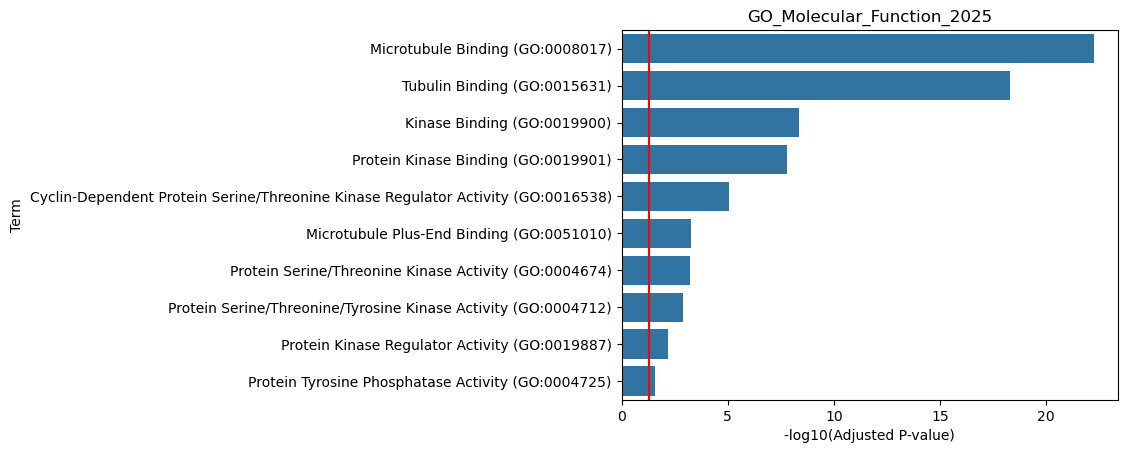

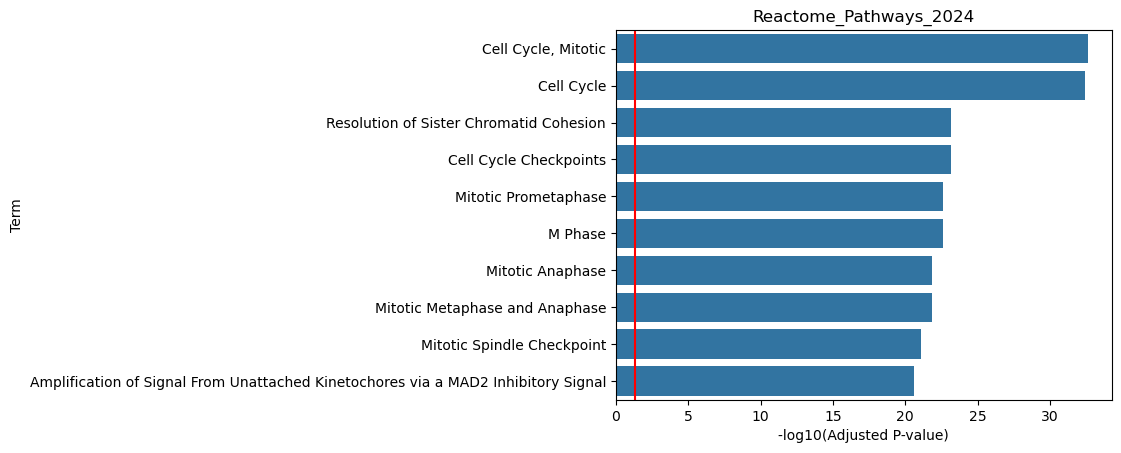

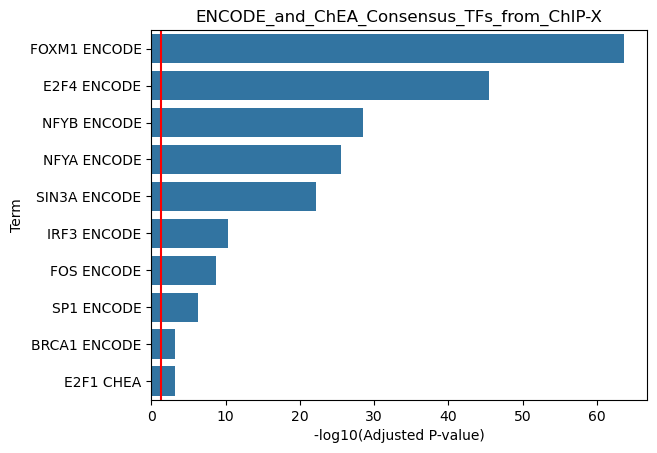

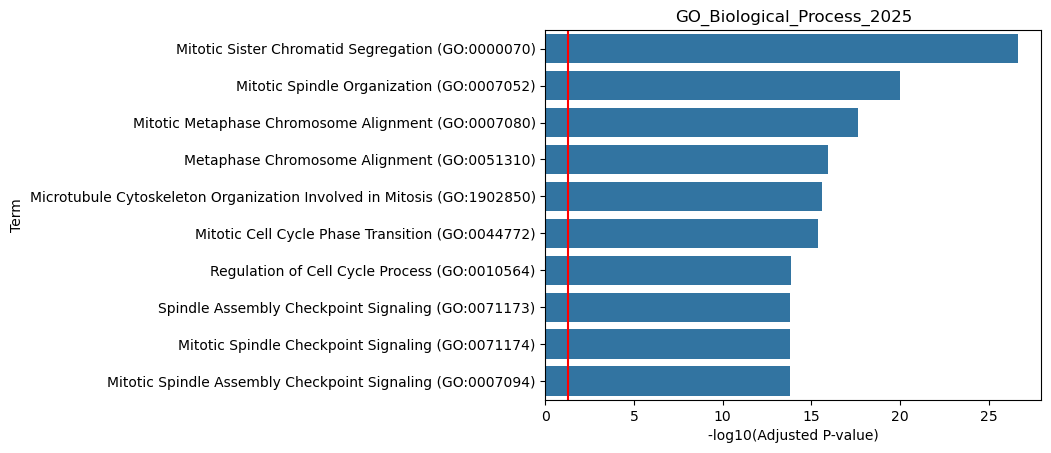

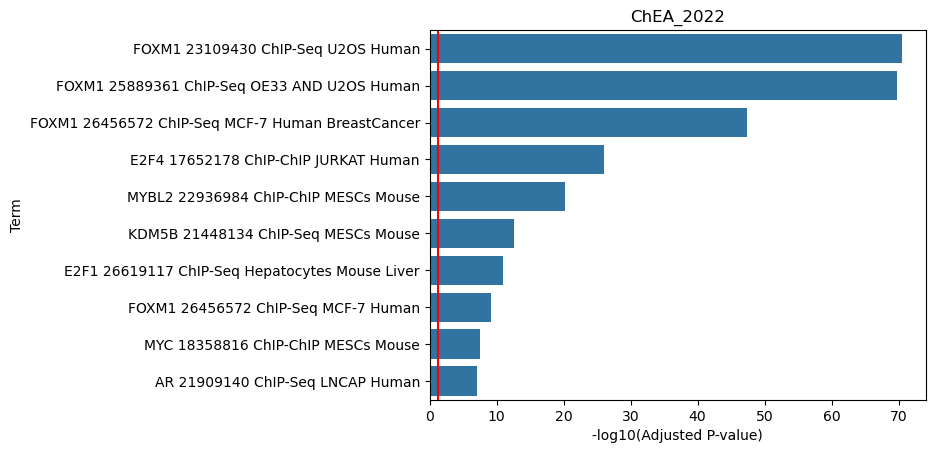

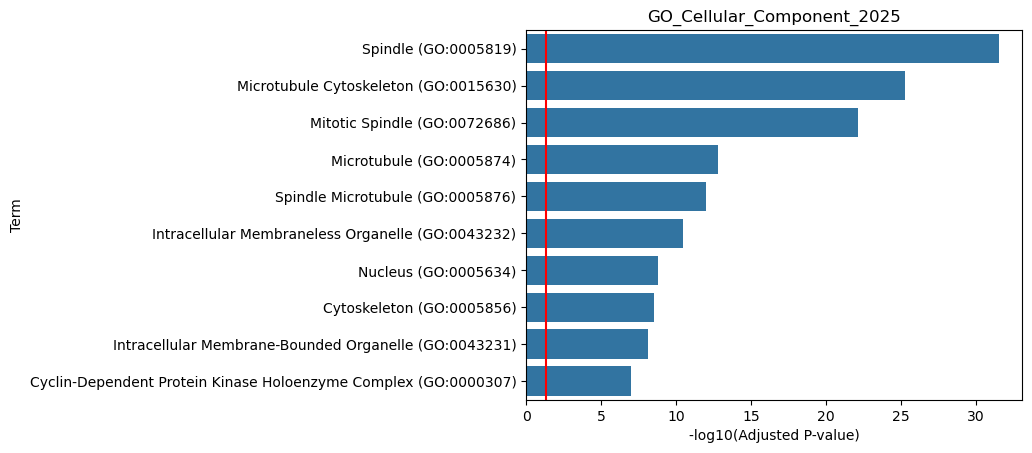

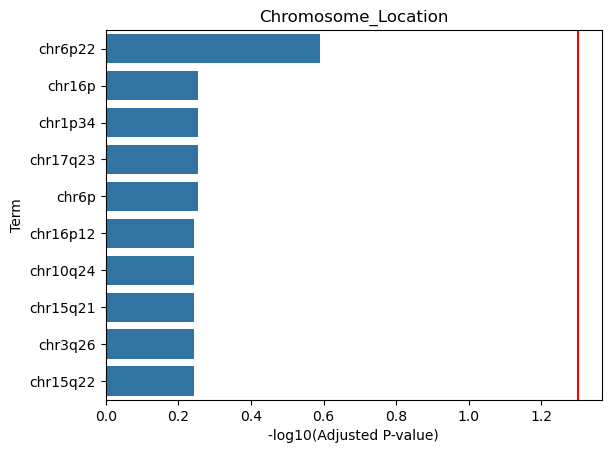

In [258]:
for value in set(cluster1['Gene_set']):
    sns.barplot(y=cluster1[cluster1['Gene_set'] == value]['Term'][0:10], x=-np.log10(cluster1[cluster1['Gene_set'] == value]['Adjusted P-value'][0:10]))
    plt.axvline(x=-np.log10(0.05), color='r')
    plt.title(value)
    plt.xlabel('-log10(Adjusted P-value)')
    plt.savefig(value+'_enrichment.svg')
    plt.savefig(value+'_enrichment.png')
    plt.savefig(value+'_enrichment.pdf')
    plt.show()
   